<a href="https://colab.research.google.com/github/silveiraluiza/machine-learning/blob/main/Weight_Lifiting_Dataset_V%C3%A1rios_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UNIVERSIDADE FEDERAL DE PERNAMBUCO
CENTRO DE INFORMÁTICA
PROGRAMA DE PÓS-GRADUAÇÃO EM CIÊNCIA DA COMPUTAÇÃO
DISCIPLINA: APRENDIZAGEM DE MÁQUINA**

- Luiza Carvalho Silveira (lcs11@cin.ufpe.br)
- Andersson Alves da Silva (aas9@cin.ufpe.br)
- Emerson Lima do Nascimento (eln3@cin.ufpe.br)


**Dados Desbalanceados e redução de dimensionalidade - Realizar o tratamento dos dados da base Weight Lifting Exercises com respeito ao desbalanceamento e redução de dimensionalidade?**
- Considerar a base de dados Weight Lifting Exercises (https://archive.ics.uci.edu/ml/datasets/Weight+Lifting+Exercises+monitored+with+Inertial+Measurement+Units) para a realização de experimentos visando definir uma abordagem de tratamento de dados desbalanceados e redução da dimensionalidade de modo a melhorar o desempenho de generalização do modelo.  Desse modo, é importante considerar a base original (sem tratamento de dados desbalanceados e redução de dimensionalidade) para uma primeira rodada de experimentos.
Será necessário realizar todas as etapas de exploração, pré-processamento e adoção do k-fold 5x2. Considerar todos os modelos de classificação já vistos na disciplina e apenas um ensemble, o Random Forest. Realizar ajuste de parâmetros dos modelos de classificação. Apresentar relatório com discussão a respeito dos resultados obtidos.


## LINK DO RELATÓRIO EM PDF:
https://drive.google.com/file/d/1-tUKx8Zp4TJEfXsWTd2_Zy_WkxmMVRpU/view?usp=sharing

### LINK DO RELATÓRIO EM PDF: https://drive.google.com/file/d/1-tUKx8Zp4TJEfXsWTd2_Zy_WkxmMVRpU/view?usp=sharing

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from math import sqrt
import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Importando e Explorando os Dados

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/data/Cpt_weight_lifting_exercises_biceps_curl_variations.csv', sep=',')

# Visualização dos dados 
print(data.shape)
data.head(10)

# Deletando informações que possivelmente não irão contribuir para o modelo (informações de data)
data = data.drop(["cvtd_timestamp","raw_timestamp_part_1", "raw_timestamp_part_2"],1)

(4024, 159)


### Média, desvio padrão, min, max e quartis de todas as variáveis numéricas


In [ ]:
data.describe() 

,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,max_roll_belt,max_picth_belt,max_yaw_belt,min_roll_belt,min_pitch_belt,min_yaw_belt,amplitude_pitch_belt,amplitude_yaw_belt,var_total_accel_belt,avg_roll_belt,stddev_roll_belt,var_roll_belt,avg_pitch_belt,stddev_pitch_belt,var_pitch_belt,avg_yaw_belt,stddev_yaw_belt,var_yaw_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,roll_arm,pitch_arm,yaw_arm,total_accel_arm,avg_pitch_arm,stddev_pitch_arm,gyros_arm_x,gyros_arm_y,...,max_picth_dumbbell,max_yaw_dumbbell,min_roll_dumbbell,min_pitch_dumbbell,min_yaw_dumbbell,amplitude_roll_dumbbell,amplitude_pitch_dumbbell,amplitude_yaw_dumbbell,total_accel_dumbbell,avg_pitch_dumbbell,stddev_pitch_dumbbell,stddev_yaw_dumbbell,gyros_dumbbell_x,gyros_dumbbell_y,gyros_dumbbell_z,accel_dumbbell_x,accel_dumbbell_y,accel_dumbbell_z,magnet_dumbbell_x,magnet_dumbbell_y,magnet_dumbbell_z,roll_forearm,pitch_forearm,yaw_forearm,max_roll_forearm,max_picth_forearm,min_roll_forearm,min_pitch_forearm,amplitude_roll_forearm,amplitude_pitch_forearm,total_accel_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.0,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,88.000000,88.000000,4024.000000,4024.000000,...,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.0,4024.000000,88.000000,88.000000,88.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,46.327535,73.308342,14.158009,-30.974709,12.767644,-28.148864,14.068182,-0.619318,-34.126136,11.443182,-0.619318,4.954545,0.0,0.978409,72.630682,1.773864,8.906818,13.987500,0.682955,1.415909,-30.773864,2.454545,303.176477,-0.182284,-0.008837,-0.246446,-24.362823,39.843688,-94.726143,24.645378,582.653827,-340.861829,40.005241,-10.538844,2.768096,24.885437,-99.414168,100.018380,-0.185169,-0.181769,...,88.104545,0.330682,-27.514773,15.459091,0.330682,61.786023,72.648636,0.0,12.019384,27.402840,125.501216,161.181998,0.248685,-0.046737,-0.133658,-7.091203,12.833499,16.633946,10.545229,-115.719433,-41.122266,36.095527,18.565331,17.789836,33.587500,111.809091,3.005682,-81.850000,30.577841,193.659091,34.375000,0.107614,-0.004108,0.093022,-6.444583,171.466203,-162.968936,-348.663767,358.638668,475.231113
std,25.709134,62.207339,18.766999,64.663731,8.193013,67.614596,8.091141,1.530972,64.781780,8.234854,1.530972,22.198948,0.0,2.196625,62.669946,2.415253,17.616194,18.995068,0.972994,5.178357,63.670368,17.333907,2836.585462,0.318171,0.057817,0.289511,25.528431,33.001362,95.787395,78.368320,29.340251,92.032207,101.331148,30.295532,91.373605,12.543835,257.817549,113.281495,2.193637,1.047446,...,77.668685,1.716275,37.852468,74.815535,1.716275,42.128770,54.724632,0.0,9.064802,319.276586,126.896019,171.756784,0.404754,0.700889,0.362490,76.384237,74.456931,99.056252,473.835454,473.677981,98.242581,119.143946,33.386175,112.954220,40.378442,98.986190,25.799209,122.138705,24.252085,169.403251,6.708725,0.540884,2.267832,0.735418,133.487861,193.468617,80.826582,265.421967,520.255942,293.009818
min,1.000000,-28.900000,-56.200000,-179.000000,0.000000,-94.400000,3.000000,-3.300000,-179.000000,0.000000,-3.300000,0.000000,0.0,0.000000,-27.400000,0.000000,0.000000,-49.400000,0.000000,0.000000,-94.400000,0.000000,0.000000,-

### Média, desvio padrão, min, max e quartis de todas as variáveis numéricas agrupado por usuário


In [ ]:
data.groupby(["user_name"]).describe() 

num_window                              ... magnet_forearm_z                       
               count       mean        std   min  ...              25%    50%     75%     max
user_name                                         ...                                        
adelmo         311.0   6.659164   1.920913   4.0  ...           164.50  495.0  663.00   969.0
carlitos      1580.0  28.544937   9.953655  11.0  ...           321.75  471.0  569.00   896.0
eurico          88.0   1.465909   0.501695   1.0  ...          -741.75 -494.0 -296.75  -249.0
jeremy           4.0   3.000000   0.000000   3.0  ...           776.50  777.0  778.00   781.0
pedro         2041.0  68.157276  13.195263  46.0  ...           500.00  644.0  707.00  1040.0

[5 rows x 808 columns]

Com esse agrupamento conseguimos observar um desbalanceamento grande entre os dados coletados para cada usuário, onde carlitos e pedro possuem uma quantidade superior de dados em relação ao restante e jeremy quase não possui dados coletados.

(array([  88.,    4.,  311., 1580., 2041.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <a list of 5 Patch objects>)

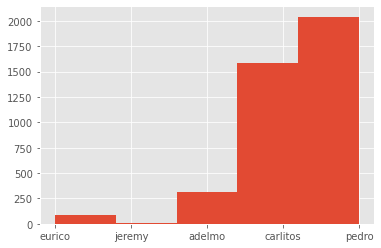

In [ ]:
plt.style.use('ggplot')
plt.hist(data["user_name"], bins=5)

### Média, desvio padrão, min, max e quartis de todas as variáveis numéricas agrupado por classe


In [ ]:
data.groupby(["classe"]).describe() 

num_window                              ... magnet_forearm_z                       
            count       mean        std   min  ...              25%    50%     75%     max
classe                                         ...                                        
A          1365.0  46.364835  18.939832  11.0  ...           469.00  576.0  657.00   789.0
B           901.0  78.485017   5.519365  69.0  ...           385.00  682.0  742.00  1040.0
C           112.0  90.169643   0.792855  89.0  ...           588.00  717.5  838.75   948.0
D           276.0  21.463768   1.660928  19.0  ...           307.75  444.0  563.00   684.0
E          1370.0  26.566423  14.526479   1.0  ...            46.25  500.5  603.00   969.0

[5 rows x 808 columns]

Com esse agrupamento já conseguimos identificar alguns padrões entre as classes, por exemplo a média de pitch belt da maioria delas gira em torno de 21-26, mas na classes D e E temos uma média mais baixa, os desvios padrões dessa variável também nos informam que para todas as classes menos a A e a E não há muita variância. Dessa maneira conseguimos ver que existem algumas variáveis que diferenciam razoavelmente bem as classes.

(array([1370., 1365.,  276.,  901.,  112.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <a list of 5 Patch objects>)

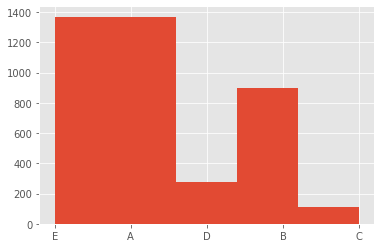

In [ ]:
plt.style.use('ggplot')
plt.hist(data["classe"], bins=5)

Também conseguimos ver que há um desbalanceamento entre as classes, sendo as classes E, A e B as mais representadas pelos dados.

## Dados Nulos

Nesse gráfico o que está preenchido com preto são dados não nulos, além disso há uma barra no lado direito deste diagrama. Este é um gráfico de linha para a integridade dos dados de cada linha.

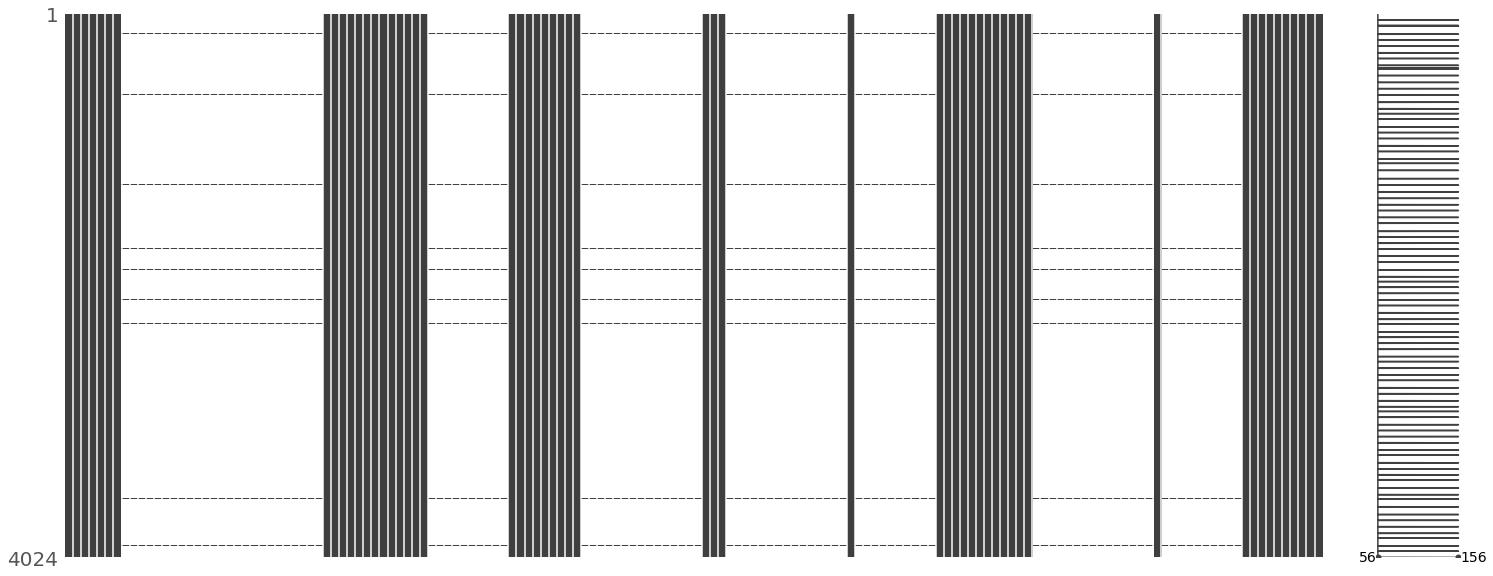

In [ ]:
import missingno as msno
msno.matrix(data)

Conseguimos observar uma quantidade grande de dados nulos no dataset, 100 colunas das 156 possuem mais de 90% de dados nulos

In [ ]:
filtered_df = data.dropna(thresh=data.shape[0]*0.9,how='all',axis=1)
filtered_df.shape

(4024, 56)

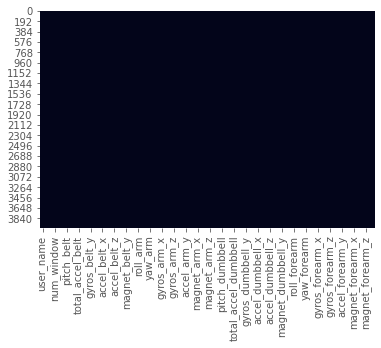

In [ ]:
sns.heatmap(filtered_df.isnull(), cbar=False)

No entanto não existem dados nulos nas 59 colunas restantes.

### Matriz de Correlação

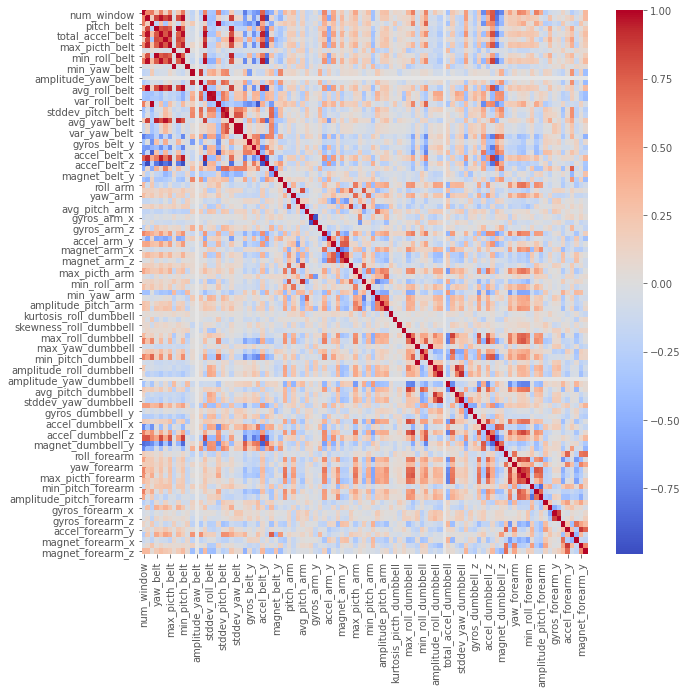

In [ ]:
# Visualizando a matriz de correlação
corr = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap= 'coolwarm')
plt.show()


Existem algumas correlações fortes tanto negativas quanto positivas entre algumas colunas do dataset, mas em geral as colunas tendem a ter correlações mais médias ou neutras.

### Matriz de Correlação sem colunas nulas

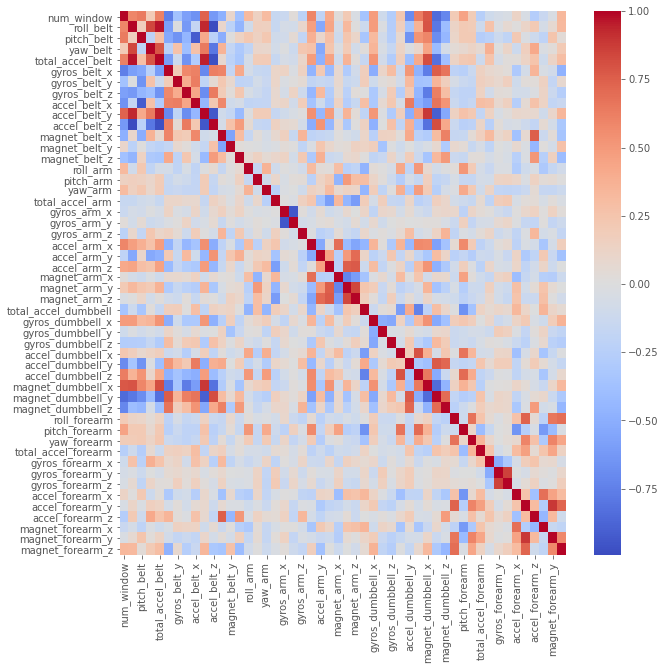

In [ ]:
# Visualizando a matriz de correlação
corr = filtered_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap= 'coolwarm')
plt.show()


# Stratified K-Fold para a base original 

## SVM

In [ ]:
from sklearn.metrics import accuracy_score

data_na_filled = data.fillna(data.mean())
y = data_na_filled[["classe"]].values
X = data_na_filled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

def SVM_tunning(df, target):
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=2673512)
    kernels = np.array(['linear', 'poly', 'rbf', 'sigmoid'])  
    acur_total = np.array([])
    
    for i in kernels:   
        acur_kernel = np.array([])      
        for train_index, test_index in skf.split(df, target):
            
            x_train, x_test = df[train_index], df[test_index]
            y_train, y_test = target[train_index], target[test_index]
        
            classifier = svm.SVC(kernel = i)
            classifier.fit(x_train, np.ravel(y_train))
            
            y_pred = classifier.predict(x_test)
            acur_kernel = np.append(acur_kernel, metrics.accuracy_score(y_test, y_pred))
        
        acur_total = np.append(acur_total, np.mean(acur_kernel))
    print("Linear:", acur_total[0])
    print("Poly:", acur_total[1])
    print("RBF:", acur_total[2])
    print("Sigmoid:", acur_total[3])
SVM_tunning(X, y)


Linear: 0.9983847841537653
Poly: 0.9403575291245636
RBF: 0.9357604832977968
Sigmoid: 0.6283509471277154


## MLP

In [ ]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score

data_na_filled = data.fillna(data.mean())
y = data_na_filled[["classe"]].values
X = data_na_filled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

def MLP_tunning(df,target):
    
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=2673512)
    
    acur_total = np.array([])
    #hidden_layer = np.arange([10, 30, 50, 70, 100])
    
    for i in [10, 30, 50, 70, 100]:
    
        acur_kernel = np.array([])
        
        for train_index, test_index in skf.split(df, target):
            
            x_train, x_test = df[train_index], df[test_index]
            y_train, y_test = target[train_index], target[test_index]
        
            classifier = MLPClassifier(hidden_layer_sizes=(i,), activation='relu', alpha=0.0001, learning_rate='adaptive', momentum=0.9, max_iter=1000)        
            classifier.fit(x_train, np.ravel(y_train))
            
            y_pred = classifier.predict(x_test)
            acur_kernel = np.append(acur_kernel, metrics.accuracy_score(y_test, y_pred))
        
        acur_total = np.append(acur_total, np.mean(acur_kernel))
    print(acur_total)
    #print("A quantidade ideal de neurônios na camada escondida é", hidden_layer[np.argmax(acur_total)])

MLP_tunning(X, y)

[0.9396179  0.99018294 0.97651911 0.99229675 0.97838169]


NameError: ignored

## KNN

In [ ]:
from sklearn.metrics import accuracy_score

data_na_filled = data.fillna(data.mean())
y = data_na_filled[["classe"]].values
X = data_na_filled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

def KNN_tunning(df, target):
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=2673512)
    vizinhos = np.arange(3, 5, 7)  
    acur_total = np.array([])
    
    for i in [3, 5, 7]:  
        acur_vizinho = np.array([])       
        for train_index, test_index in skf.split(df, target):
            
            x_train, x_test = df[train_index], df[test_index]
            y_train, y_test = target[train_index], target[test_index]
        
            classifier = KNeighborsClassifier(n_neighbors = i)
            classifier.fit(x_train, np.ravel(y_train))
            
            y_pred = classifier.predict(x_test)
            acur_vizinho = np.append(acur_vizinho, metrics.accuracy_score(y_test, y_pred))
        
        acur_total = np.append(acur_total, np.mean(acur_vizinho))
    print("K=3:", acur_total[0])
    print("Acur_total", acur_total)
    #print("K=5:", acur_total[1])
    #print("K=7:", acur_total[2])
KNN_tunning(X, y)
#print(acur_total)

K=3: 0.9940355675040944
Acur_total [0.99403557 0.98745033 0.97875143]


## Árvore de decisão

In [ ]:
y = data[["classe"]].values
X = data.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

def Tree_tunning(df, target):
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=2673512)
    estimators = np.array([10, 20, 30])    
    acur_total = np.array([])
    
    for i in estimators:    
        acur_tree = np.array([])       
        for train_index, test_index in skf.split(df, target):          
            x_train, x_test = df[train_index], df[test_index]
            y_train, y_test = target[train_index], target[test_index]
        
            classifier = xgb.XGBClassifier(objective ='multi:softmax', colsample_bytree = 0.3, learning_rate = 0.1,
                    max_depth = 5, alpha = 10, n_estimators = i, num_class = 5)
            classifier.fit(x_train, np.ravel(y_train))
            
            y_pred = classifier.predict(x_test)
            acur_tree = np.append(acur_tree, metrics.accuracy_score(y_test, y_pred))       
        acur_total = np.append(acur_total, np.mean(acur_tree))
    print("n_estimators = 10:", acur_total[0])
    print("n_estimators = 20:", acur_total[1])
    print("n_estimators = 30:", acur_total[2])

Tree_tunning(X, y)

n_estimators = 10: 0.9998757763975157
n_estimators = 20: 1.0
n_estimators = 30: 1.0


## Random Forest

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

data_na_filled = data.fillna(data.mean())
y = data_na_filled[["classe"]].values
X = data_na_filled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

def Ensemble_tunning(df, target):
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=2673512)
    estimators = np.array([10, 20, 30])    
    acur_total = np.array([])
    
    for i in estimators:    
        acur_RF = np.array([])        
        for train_index, test_index in skf.split(df, target):            
            x_train, x_test = df[train_index], df[test_index]
            y_train, y_test = target[train_index], target[test_index]       
            classifier = RandomForestClassifier(n_estimators=i, random_state=42)
            classifier.fit(x_train, np.ravel(y_train))
            
            y_pred = classifier.predict(x_test)
            acur_RF = np.append(acur_RF, metrics.accuracy_score(y_test, y_pred))
        
        acur_total = np.append(acur_total, np.mean(acur_RF))
    print("Acuracia total:", acur_total)
    #print("n_estimators=10:", acur_total[0])
    #print("n_estimators=20:", acur_total[1])
    #print("n_estimators=30:", acur_total[2])
Ensemble_tunning(X, y)


Acuracia total: [0.99167486 0.99565017 0.99714116]


## Corrigindo o desbalanceamento de classes com OverSampling

In [ ]:
size = filtered_df.shape[0]/5
size = round(size)
size

805

In [ ]:
from sklearn.utils import resample

print("filtered_df inicial", filtered_df.shape)

print(filtered_df.classe.value_counts())

df_C = filtered_df[filtered_df.classe=="C"]
df_D = filtered_df[filtered_df.classe=="D"]
df_A = filtered_df[filtered_df.classe=="A"]
df_B = filtered_df[filtered_df.classe=="B"]
df_E = filtered_df[filtered_df.classe=="E"]

 
# Upsample minority class
df_C_up = resample(df_C, 
                                 replace=True,     # sample with replacement
                                 n_samples=size,    # to match majority class
                                 random_state=123) # reproducible results

# Upsample minority class
df_D_up = resample(df_D, 
                                 replace=True,     # sample with replacement
                                 n_samples=size,    # to match majority class
                                 random_state=123) # reproducible results



# Combine majority class with upsampled minority class
df_upsampled = pd.concat([ df_D_up, df_C_up, df_A, df_B, df_E])
 
# Display new class counts
df_upsampled.classe.value_counts()



filtered_df inicial (4024, 56)
E    1370
A    1365
B     901
D     276
C     112
Name: classe, dtype: int64


E    1370
A    1365
B     901
D     805
C     805
Name: classe, dtype: int64

In [ ]:
size = 203

print("filtered_df inicial", filtered_df.shape)

print(filtered_df.classe.value_counts())

df_C = filtered_df[filtered_df.classe=="C"]
df_D = filtered_df[filtered_df.classe=="D"]
df_A = filtered_df[filtered_df.classe=="A"]
df_B = filtered_df[filtered_df.classe=="B"]
df_E = filtered_df[filtered_df.classe=="E"]

 

df_A_down = resample(df_A, 
                                 replace=False,     
                                 n_samples=size,    
                                 random_state=123) # reproducible results

df_B_down = resample(df_B, 
                                 replace=False,     
                                 n_samples=size,    
                                 random_state=123) # reproducible results

df_E_down = resample(df_E, 
                                 replace=False,    
                                 n_samples=size,    
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_downsampled = pd.concat([ df_E_down, df_B_down, df_A_down, df_C, df_D])
 
# Display new class counts
df_downsampled.classe.value_counts()

 

filtered_df inicial (4024, 56)
E    1370
A    1365
B     901
D     276
C     112
Name: classe, dtype: int64


D    276
E    203
A    203
B    203
C    112
Name: classe, dtype: int64

# Stratified K-Fold com dataset tratado + OverSample


## SVM

In [ ]:
y = df_upsampled[["classe"]].values
X = df_upsampled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

SVM_tunning(X, y)

Linear: 0.9989515638476553
Poly: 0.9663544418720775
RBF: 0.9632088610468019
Sigmoid: 0.5395534976621726


## MLP

In [ ]:
y = df_upsampled[["classe"]].values
X = df_upsampled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

MLP_tunning(X, y)

[0.99466258 0.99885633 0.99904689 0.99857034 0.99837977]


NameError: ignored

## KNN

In [ ]:
y = df_upsampled[["classe"]].values
X = df_upsampled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

KNN_tunning(X, y)

K=3: 0.995234736029779
Acur_total [0.99523474 0.98770539 0.97855509]


## Árvore de Decisão

In [ ]:
y = df_upsampled[["classe"]].values
X = df_upsampled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

Tree_tunning(X, y)

n_estimators = 10: 1.0
n_estimators = 20: 1.0
n_estimators = 30: 1.0


## Random Forest

In [ ]:
y = df_upsampled[["classe"]].values
X = df_upsampled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

Ensemble_tunning(X, y)

Acuracia total: [0.99837959 0.9993327  0.9993327 ]


# Stratified K-Fold com dataset tratado + Undersample

## SVM

In [ ]:
y = df_downsampled[["classe"]].values
X = df_downsampled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values
SVM_tunning(X, y)


Linear: 0.987464824120603
Poly: 0.9372914572864322
RBF: 0.9182437185929647
Sigmoid: 0.6479623115577889


## MLP

In [ ]:
y = df_downsampled[["classe"]].values
X = df_downsampled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

MLP_tunning(X, y)

[0.9844397]
A quantidade ideal de neurônios na camada escondida é 50


## KNN

In [ ]:
y = df_downsampled[["classe"]].values
X = df_downsampled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

KNN_tunning(X, y)

K=3: 0.9418241206030149
Acur_total [0.94182412 0.91875126 0.90522111]


## Árvore de Decisão

In [ ]:
y = df_downsampled[["classe"]].values
X = df_downsampled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

Tree_tunning(X, y)

n_estimators = 10: 0.9894773869346732
n_estimators = 20: 0.9954824120603016
n_estimators = 30: 0.9969874371859297


## Random Forest

In [ ]:
y = df_downsampled[["classe"]].values
X = df_downsampled.drop(['classe',],1)
X = pd.get_dummies(X) # one hot encoding para dados nominais
X = X.values

Ensemble_tunning(X, y)

Acuracia total: [0.98544724 0.9934799  0.99548492]
